In [103]:
import numpy as np
import anndata as ad
import scanpy as sc
import squidpy as sq
import pandas as pd
import scipy.io

import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [254]:
def load_slideseq_puck(puck_directory):
    # Load the counts and positions
    counts_file = puck_directory / "MappedDGEForR.csv"
    pos_file = puck_directory / "BeadLocationsForR.csv"

    pos = pd.read_csv(pos_file, index_col=0)
    counts = pd.read_csv(counts_file, index_col=0) # Takes a while, ~10min

    # Align the indices
    counts = counts.loc[:, pos.index]
    barcodes = pos.index.values

    # Swap position axes
    # We swap x'=y and y'=-x to match the slides in the paper
    pos = pd.DataFrame(
        {
            'X': pos.ycoord,
            'Y': pos.xcoord*-1,
        }, index=pos.index
    )

#     num_umi = counts.sum(axis=0)

    return counts, pos

In [257]:
stacked_counts = []
stacked_pos = []
for slice_number in ["13", "17", "18", "19", "22", "23"]:
    counts, pos = load_slideseq_puck(puck_directory / f"Puck_180531_{slice_number}")
    stacked_counts.append(counts)
    stacked_pos.append(pos)

KeyboardInterrupt: 

In [3]:
# Filter genes
gene_counts = (counts > 0).sum(axis=1)
valid_genes = gene_counts >= 50
counts = counts.loc[valid_genes]

NameError: name 'counts' is not defined

## Loading the pseudo-3D Slide-seq dataset

In [2]:
puck_directory = Path("/work/magroup/shahula/spatiotemporal_transcriptomics_integration/data/slideseq/hippocampal_pseudo_3D/")

### Preprocessed STAGATE version...

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
#import STAGATE_pyG

data = pd.read_csv(puck_directory / "STAGATE_preprocessed" /'3D_Hippo_expression.txt', sep='\t', index_col=0)
Aligned_coor = pd.read_csv(puck_directory / "STAGATE_preprocessed" / 'ICP_Align_Coor.txt', sep='\t', index_col=0)

Aligned_coor.head()

adata = sc.AnnData(data)
adata

AnnData object with n_obs × n_vars = 10908 × 9420

In [9]:
adata.obs['X'] = Aligned_coor.loc[adata.obs_names, 'X']
adata.obs['Y'] = Aligned_coor.loc[adata.obs_names, 'Y']
adata.obs['Z'] = Aligned_coor.loc[adata.obs_names, 'Z']
adata.obs['Section_id'] = Aligned_coor.loc[adata.obs_names, 'Section']

In [6]:
#Normalization
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [10]:
adata

AnnData object with n_obs × n_vars = 10908 × 9420
    obs: 'X', 'Y', 'Z', 'Section_id'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p'

In [11]:
adata.obsm['spatial'] = adata.obs.loc[:, ['X', 'Y']].values

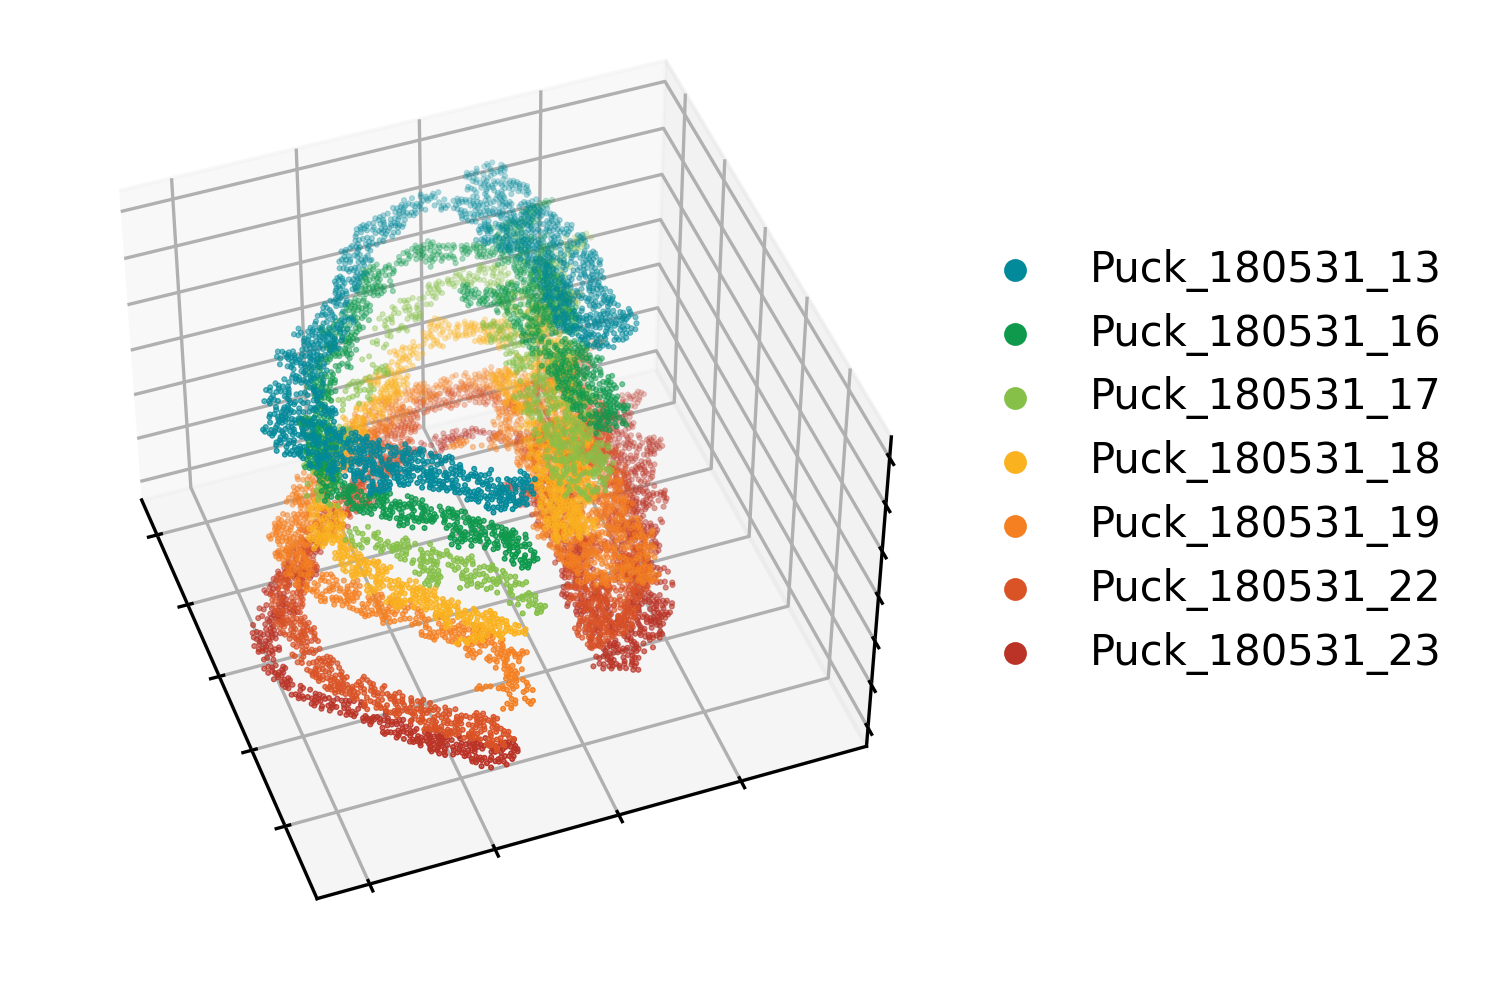

In [13]:
section_colors = ['#02899A', '#0E994D', '#86C049', '#FBB21F', '#F48022', '#DA5326', '#BA3326']
fig = plt.figure(figsize=(4, 4), dpi=300)
ax1 = plt.axes(projection='3d')
for it, label in enumerate(np.unique(adata.obs['Section_id'])):
    temp_Coor = adata.obs.loc[adata.obs['Section_id']==label, :]
    temp_xd = temp_Coor['X']
    temp_yd = temp_Coor['Y']
    temp_zd = temp_Coor['Z']
    ax1.scatter3D(temp_xd, temp_yd, temp_zd, c=section_colors[it],s=0.2, marker="o", label=label)

ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_zlabel('')

ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.set_zticklabels([])

plt.legend(bbox_to_anchor=(1,0.8), markerscale=10, frameon=False)

ax1.elev = 45
ax1.azim = -20

plt.show()

## Simulating realistic spatial patterns across FOVs

In [15]:
data_directory = Path("../../data/squidpy_datasets/")
adata = sq.datasets.merfish(data_directory)
sc.pl.embedding(adata, basis="spatial3d", projection="3d", color="Cell_class")

  0%|          | 0.00/49.2M [00:00<?, ?B/s]

KeyboardInterrupt: 

## Exploring BGI Stereo-seq mouse embryo

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [18]:
mouse_embryo = pd.read_csv("../../data/stereoseq/mouse_embryo_development/E10.5_E1S3_GEM_bin1.tsv", delimiter="\t", nrows=30000)

In [19]:
mouse_embryo

,geneID,x,y,MIDCounts
0,0610005C13Rik,3614,7988,1
1,0610005C13Rik,7811,8950,1
2,0610005C13Rik,7611,4790,1
3,0610005C13Rik,7478,3573,1
4,0610005C13Rik,5361,7425,1
...,...,...,...,...
29995,0610010K14Rik,7773,3124,1
29996,0610010K14Rik,5542,7198,1
29997,0610010K14Rik,6341,6955,1
29998,0610010K14Rik,8058,5567,1


In [21]:
mouse_embryo_slice = ad.read_h5ad("../../data/stereoseq/mouse_embryo_development/E16.5_E1S1.MOSTA.h5ad")

In [22]:
mouse_embryo_slice_2 = ad.read_h5ad("../../data/stereoseq/mouse_embryo_development/E16.5_E1S2.MOSTA.h5ad")

In [123]:
np.sort(mouse_embryo_slice.obs["annotation"].unique())

array(['Adipose tissue', 'Adrenal gland', 'Bone', 'Brain', 'Cartilage',
       'Cartilage primordium', 'Cavity', 'Choroid plexus',
       'Connective tissue', 'Dorsal root ganglion', 'Epidermis',
       'GI tract', 'Heart', 'Inner ear', 'Jaw and tooth', 'Kidney',
       'Liver', 'Lung', 'Meninges', 'Mucosal epithelium', 'Muscle',
       'Smooth muscle', 'Spinal cord', 'Submandibular gland',
       'Sympathetic nerve'], dtype=object)

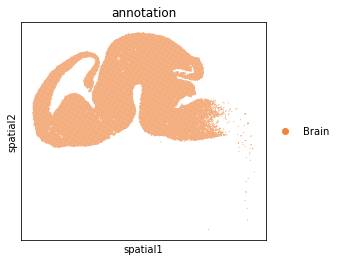

In [85]:
# x, y = mouse_embryo_slice.obsm["spatial"][:].T
# fig = plt.figure()
# ax = fig.add_subplot(111, aspect="equal")
# plt.scatter(x, y, s=0.01)
sc.pl.spatial(mouse_embryo_slice[mouse_embryo_slice.obs["annotation"] == "Brain"],
              color="annotation",
              spot_size=1)

In [72]:
from scipy.sparse import csr_matrix
def remove_connectivity_artifacts(sparse_distance_matrix, threshold=94.5):
    dense_distances = sparse_distance_matrix.toarray()
    distances = sparse_distance_matrix.data
    cutoff = np.percentile(distances, threshold)
    mask = dense_distances < cutoff
    
    return csr_matrix(dense_distances * mask)

def compute_neighborhood_enrichment(anndata_replicate, key):
    print("Constructing neighbors")
    sq.gr.spatial_neighbors(anndata_replicate, delaunay=True, coord_type="generic")
    
#     print("Removing artifacts")
#     anndata_replicate.obsp["spatial_connectivities"] = remove_connectivity_artifacts(anndata_replicate.obsp["spatial_connectivities"])
#     sc.pl.spatial(mouse_embryo_slice,
#                   neighbors_key="spatial_neighbors",
#                   color="annotation",
#                   edges=True,
#                   spot_size=1)

    print("Computing enrichment")
    sq.gr.nhood_enrichment(anndata_replicate,
                       cluster_key="annotation")
    
    return anndata_replicate

In [97]:
mouse_embryo_slice = compute_neighborhood_enrichment(mouse_embryo_slice, "annotation")

Constructing neighbors
Computing enrichment


  0%|          | 0/1000 [00:00<?, ?/s]

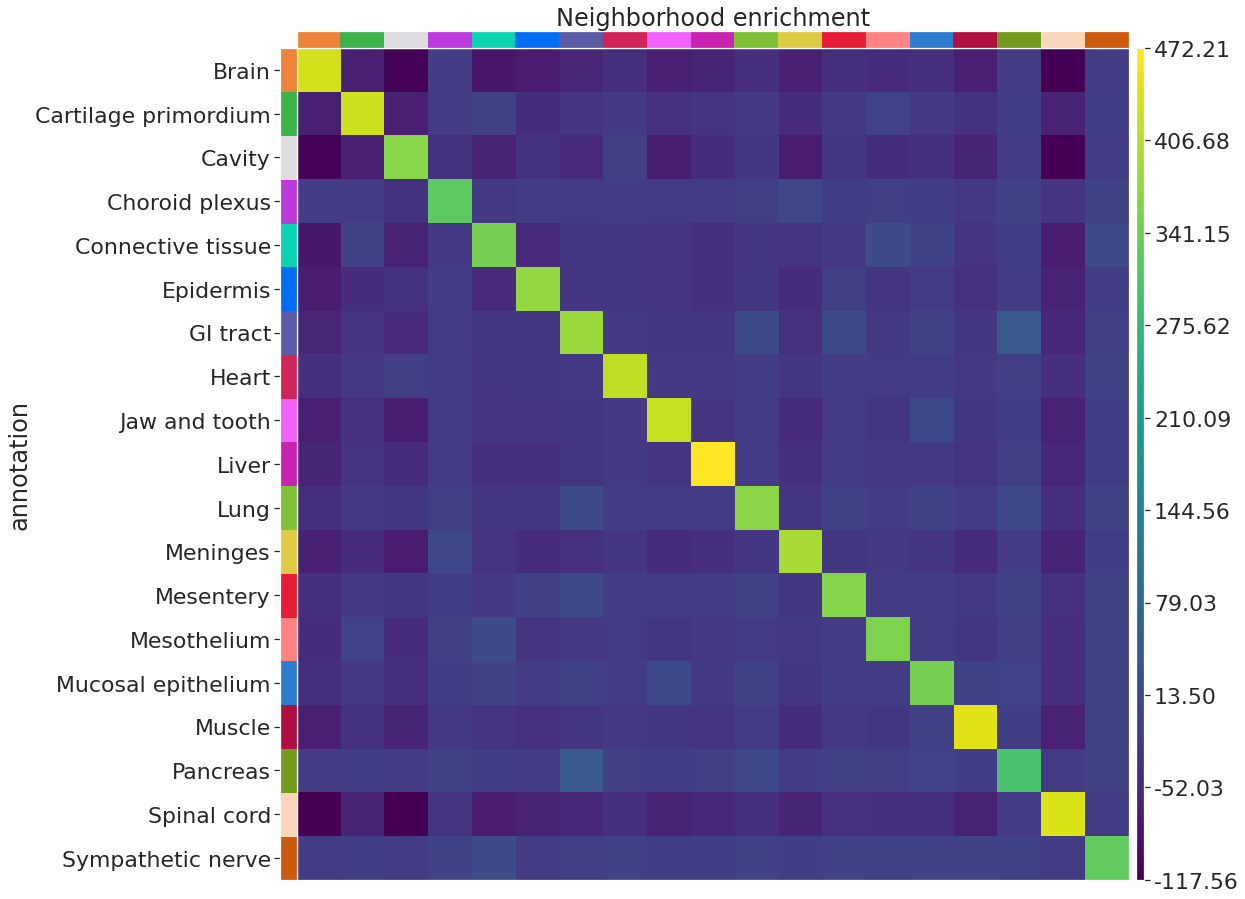

In [201]:
sq.pl.nhood_enrichment(mouse_embryo_slice,
                       cluster_key="annotation")

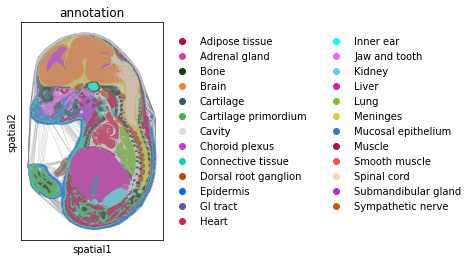

In [99]:
sc.pl.spatial(mouse_embryo_slice,
              neighbors_key="spatial_neighbors",
              color="annotation",
              edges=True,
              spot_size=1)

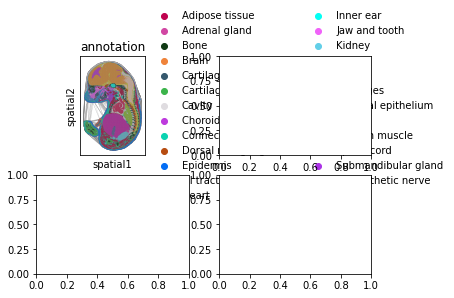

In [120]:
# sq.gr.spatial_neighbors(mouse_embryo_slice, delaunay=True, coord_type="generic")
# sq.gr.nhood_enrichment(mouse_embryo_slice,
#                        cluster_key="annotation")
fig, axes = plt.subplots(2, 2)
# sq.pl.nhood_enrichment(mouse_embryo_slice,
#                        cluster_key="annotation", ax=axes[0, 1])
sc.pl.spatial(mouse_embryo_slice,
              neighbors_key="spatial_neighbors",
              color="annotation",
              spot_size=1,
              ax = axes[0, 0])

In [107]:
# sc.metrics.morans_i(mouse_embryo_slice, use_graph="spatial_neighbors", obsm="annotation")
def compute_spatial_statistic_over_classes(anndata, key, statistic_function=sc.metrics.morans_i):
    statistics = {}
    classes = anndata.obs["annotation"].unique()
    for unique_class in classes:
        statistic = statistic_function(anndata.obsp["spatial_connectivities"], anndata.obs["annotation"] == unique_class)
        statistics[unique_class] = statistic
        
    return statistics

morans_i = compute_spatial_statistic_over_classes(mouse_embryo_slice, "annotation", sc.metrics.morans_i)
gearys_c = compute_spatial_statistic_over_classes(mouse_embryo_slice, "annotation", sc.metrics.gearys_c)

In [ ]:
data_directory = Path("../../data/stereoseq/mouse_embryo_development/")
neighborhood_enrichments = {}
tissues = {}
morans_i = {}
gearys_c = {}
for file in data_directory.glob("*E1S1*.h5ad"):
    print(file)
    mouse_embryo_slice = ad.read_h5ad(file)
    mouse_embryo_slice = compute_neighborhood_enrichment(mouse_embryo_slice, "annotation")
    neighborhood_enrichments[file.stem] = mouse_embryo_slice.uns['annotation_nhood_enrichment']['zscore']
    neighborhood_enrichments[file.stem] = np.sort(mouse_embryo_slice.obs["annotation"].unique())
    sq.pl.nhood_enrichment(mouse_embryo_slice,
                           cluster_key="annotation")
    morans_i[file.stem] = compute_spatial_statistic_over_classes(mouse_embryo_slice, "annotation", sc.metrics.morans_i)
    gearys_c[file.stem] = compute_spatial_statistic_over_classes(mouse_embryo_slice, "annotation", sc.metrics.gearys_c)

In [ ]:
filename_to_timepoint = {
    "E9.5_E1S1.MOSTA": 9.5,
    "E10.5_E1S1.MOSTA": 10.5,
    "E11.5_E1S1.MOSTA": 11.5,
    "E12.5_E1S1.MOSTA": 12.5,
    "E13.5_E1S1.MOSTA": 13.5,
    "E14.5_E1S1.MOSTA": 14.5,
    "E16.5_E1S1.MOSTA": 16.5,
}
gearys_c_dataframe = pd.DataFrame(gearys_c).T
gearys_c_dataframe["timepoint"] = gearys_c_dataframe.index.map(filename_to_timepoint)
gearys_c_dataframe = gearys_c_dataframe.sort_values(["timepoint"])

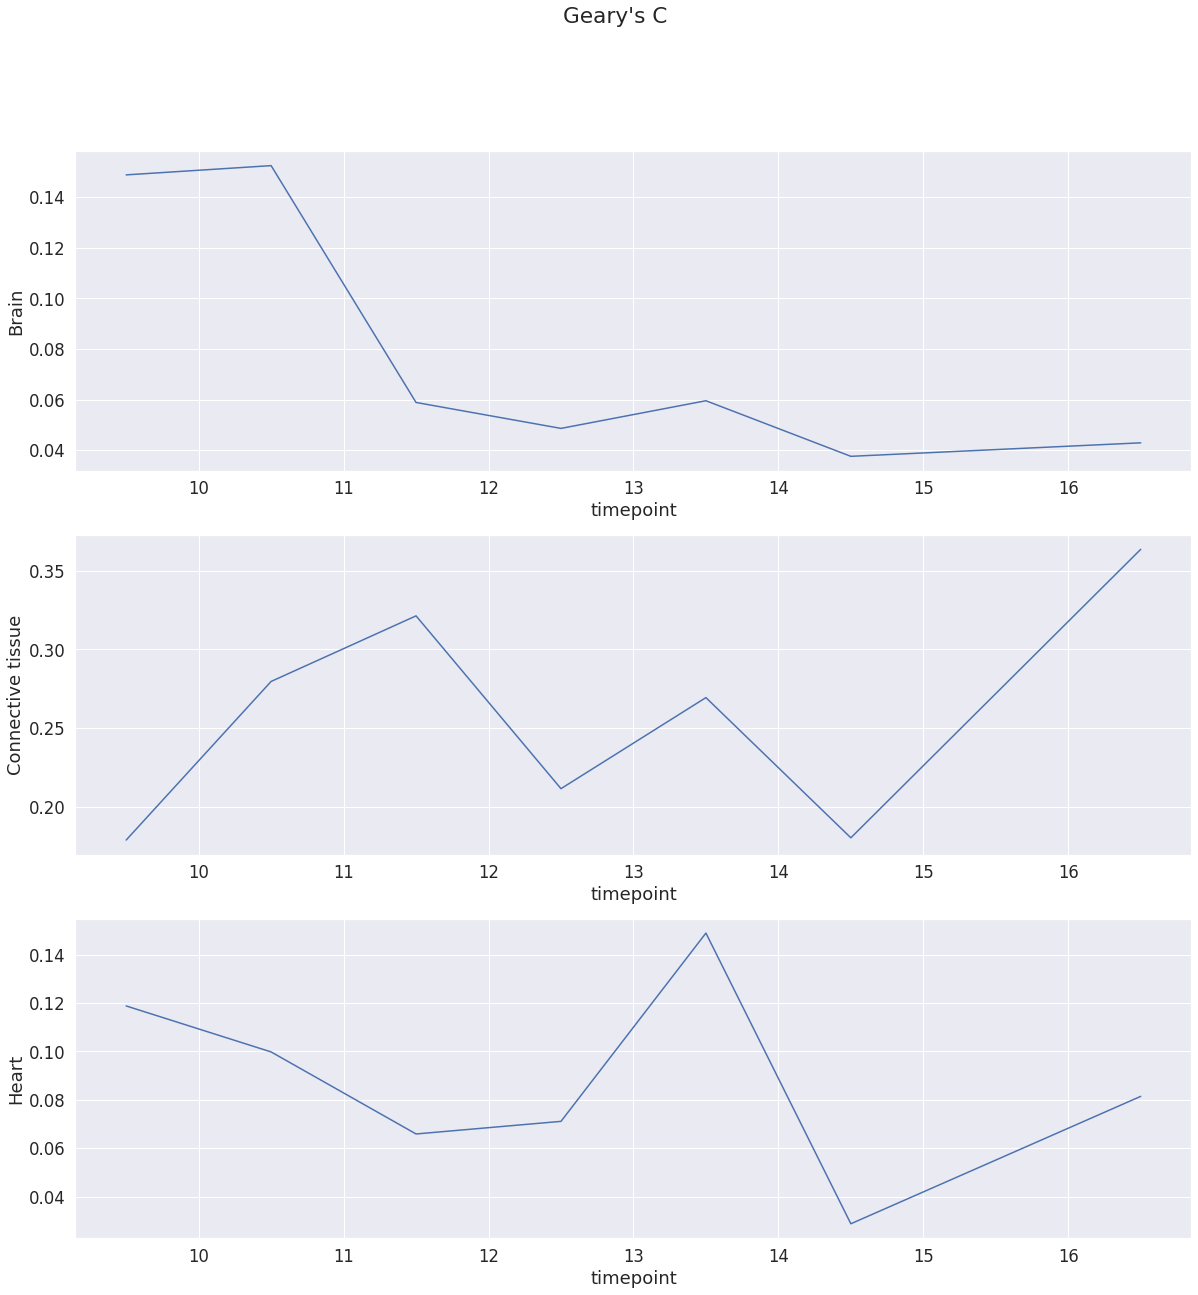

In [199]:
fig, axes = plt.subplots(3, figsize=(20,20))

sns.lineplot(data=gearys_c_dataframe, x="timepoint", y="Brain", ax=axes[0])
sns.lineplot(data=gearys_c_dataframe, x="timepoint", y="Connective tissue", ax=axes[1])
sns.lineplot(data=gearys_c_dataframe, x="timepoint", y="Heart", ax=axes[2])
plt.suptitle("Geary's C")
sns.set(font_scale=2)
# sns.set_style("white")
# fig, ax = plt.subplots()
# plt.plot(gearys_c_dataframe.timepoint, gearys_c_dataframe.Brain, "o-", ms=3,
#             color="r", label='Brain')
# plt.plot(gearys_c_dataframe.timepoint, gearys_c_dataframe.Heart, "o-", ms=3,
#             color="g", label='Heart')
# ax.legend()

In [216]:
data_directory = Path("../../data/stereoseq/mouse_embryo_development/")

for file in sorted(data_directory.glob("*.h5ad")):
    print(file)
    mouse_embryo_slice = ad.read_h5ad(file)

    brain_index = (mouse_embryo_slice.obs["annotation"] == "Brain")
    brain_filename = Path(f"{file.stem}_brain_region.h5ad")
    brain_slice = mouse_embryo_slice[brain_index]
    print(len(brain_slice))
    print(brain_filename)
    brain_slice.write(data_directory  / "brain_region" / brain_filename)

../../data/stereoseq/mouse_embryo_development/E10.5_E1S1.MOSTA.h5ad
2816
E10.5_E1S1.MOSTA_brain_region.h5ad
../../data/stereoseq/mouse_embryo_development/E10.5_E1S1.MOSTA_brain_region.h5ad
2816
E10.5_E1S1.MOSTA_brain_region_brain_region.h5ad
../../data/stereoseq/mouse_embryo_development/E10.5_E1S2.MOSTA.h5ad
3201
E10.5_E1S2.MOSTA_brain_region.h5ad
../../data/stereoseq/mouse_embryo_development/E10.5_E1S3.MOSTA.h5ad
2446
E10.5_E1S3.MOSTA_brain_region.h5ad
../../data/stereoseq/mouse_embryo_development/E10.5_E2S1.MOSTA.h5ad
589
E10.5_E2S1.MOSTA_brain_region.h5ad
../../data/stereoseq/mouse_embryo_development/E11.5_E1S1.MOSTA.h5ad
5794
E11.5_E1S1.MOSTA_brain_region.h5ad
../../data/stereoseq/mouse_embryo_development/E11.5_E1S2.MOSTA.h5ad
6481
E11.5_E1S2.MOSTA_brain_region.h5ad
../../data/stereoseq/mouse_embryo_development/E11.5_E1S3.MOSTA.h5ad
3897
E11.5_E1S3.MOSTA_brain_region.h5ad
../../data/stereoseq/mouse_embryo_development/E11.5_E1S4.MOSTA.h5ad
4745
E11.5_E1S4.MOSTA_brain_region.h5ad
../

In [217]:
ad.read_h5ad(data_directory  / "brain_region" / brain_filename)

AnnData object with n_obs × n_vars = 771 × 23398
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'annotation', 'Regulon - 2610044O15Rik8', 'Regulon - AW146154', 'Regulon - Ahrr', 'Regulon - Alx3', 'Regulon - Alx4', 'Regulon - Arid3a', 'Regulon - Arnt', 'Regulon - Arnt2', 'Regulon - Arntl', 'Regulon - Arntl2', 'Regulon - Arx', 'Regulon - Atf1', 'Regulon - Atf4', 'Regulon - Atf6', 'Regulon - Atoh7', 'Regulon - Bach1', 'Regulon - Bach2', 'Regulon - Barhl1', 'Regulon - Barhl2', 'Regulon - Barx1', 'Regulon - Batf3', 'Regulon - Bcl3', 'Regulon - Bclaf1', 'Regulon - Bdp1', 'Regulon - Bhlha15', 'Regulon - Bhlhe22', 'Regulon - Bhlhe23', 'Regulon - Bhlhe40', 'Regulon - Bmyc', 'Regulon - Brf1', 'Regulon - Brf2', 'Regulon - Cdx1', 'Regulon - Cdx2', 'Regulon - Cdx4', 'Regulon - Cebpa', 'Regulon - Cebpb', 'Regulon - Cebpd', 'Regulon - Cenpb', 'Regulon - Cers3', 'Regulon - Chd1', 'Regulon - Chd2', 'Regulon - Cic', 'Regulon - Clock', 'Regulon - Cpsf4', 'R

## Running SpiceMixPlus on Stereo-seq brain sections

In [12]:
sc.pp.log1p(mouse_brain_slice)

In [17]:
sc.pp.highly_variable_genes(mouse_brain_slice)

In [21]:
mouse_brain_slice[:, mouse_brain_slice.var["highly_variable"]]

View of AnnData object with n_obs × n_vars = 3201 × 3632
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'annotation', 'Regulon - Aire', 'Regulon - Arid3a', 'Regulon - Arnt2', 'Regulon - Ascl1', 'Regulon - Atf1', 'Regulon - Atf2', 'Regulon - Atf4', 'Regulon - Atf6', 'Regulon - Atoh7', 'Regulon - Bach1', 'Regulon - Bach2', 'Regulon - Barhl1', 'Regulon - Barhl2', 'Regulon - Batf', 'Regulon - Bclaf1', 'Regulon - Bhlhe22', 'Regulon - Bhlhe40', 'Regulon - Bmyc', 'Regulon - Borcs8', 'Regulon - Brca1', 'Regulon - Brf1', 'Regulon - Brf2', 'Regulon - Cdx2', 'Regulon - Cdx4', 'Regulon - Cebpa', 'Regulon - Cebpg', 'Regulon - Cebpz', 'Regulon - Chd1', 'Regulon - Chd2', 'Regulon - Clock', 'Regulon - Cnot3', 'Regulon - Creb1', 'Regulon - Creb3', 'Regulon - Creb3l1', 'Regulon - Creb3l2', 'Regulon - Crem', 'Regulon - Crx', 'Regulon - Ctcf', 'Regulon - Cux1', 'Regulon - D130040H23Rik', 'Regulon - Dbx1', 'Regulon - Dbx2', 'Regulon - Ddit3', 'Regulon - Dlx4'

In [29]:
from load_data import load_anndata, save_anndata
data_directory = Path("../../data/stereoseq/mouse_embryo_development/") / "brain_region"

datasets = []
replicate_names = []
for file in sorted(data_directory.glob("*.h5ad"))[:2]:
    print(file)
    replicate_names.append(file.stem)
    mouse_brain_slice = ad.read_h5ad(file)
    print(mouse_brain_slice.X.shape)
    sc.pp.log1p(mouse_brain_slice)
    datasets.append(mouse_brain_slice)

merged = ad.concat(datasets)
sc.pp.highly_variable_genes(merged)

#     sca
    
#     sq.gr.spatial_neighbors(mouse_brain_slice, delaunay=True, coord_type="generic")
#     mouse_brain_slice.obsp["spatial_connectivities"] = remove_connectivity_artifacts(mouse_brain_slice.obsp["spatial_connectivities"])
#     mouse_brain_slice.obsp["adjacency_matrix"] = mouse_brain_slice.obsp["spatial_connectivities"]
    
#     datasets.append(mouse_brain_slice)

# save_anndata(data_directory/"single_dataset_test.h5ad", datasets, replicate_names)

../../data/stereoseq/mouse_embryo_development/brain_region/E10.5_E1S1.MOSTA_brain_region.h5ad
(2816, 25201)
../../data/stereoseq/mouse_embryo_development/brain_region/E10.5_E1S2.MOSTA_brain_region.h5ad
(3201, 25544)


In [77]:
subset_dataset.obsp["adjacency_matrix"]

<2816x2816 sparse matrix of type '<class 'numpy.bool_'>'
	with 15856 stored elements in Compressed Sparse Row format>

In [76]:
dataset = ad.read_h5ad(data_directory / "E10.5_E1S1.MOSTA_brain_region.h5ad")
sc.pp.log1p(dataset)
sc.pp.highly_variable_genes(dataset)
subset_dataset = dataset[:, dataset.var["highly_variable"]]

sq.gr.spatial_neighbors(subset_dataset, delaunay=True, coord_type="generic")
subset_dataset.obsp["spatial_distances"] = remove_connectivity_artifacts(subset_dataset.obsp["spatial_distances"])
subset_dataset.obsp["spatial_connectivities"] = subset_dataset.obsp["spatial_distances"] > 0
subset_dataset.obsp["adjacency_matrix"] = subset_dataset.obsp["spatial_connectivities"]
subset_dataset.X = subset_dataset.X.toarray()

save_anndata(data_directory / "single_dataset_test.h5ad", [subset_dataset], ["E10.5_E1S1.MOSTA_brain_region"])

AnnData object with n_obs × n_vars = 2816 × 3687
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'annotation', 'Regulon - 6720489N17Rik', 'Regulon - Aebp2', 'Regulon - Ahr', 'Regulon - Arid3a', 'Regulon - Arnt', 'Regulon - Arx', 'Regulon - Atf2', 'Regulon - Atf4', 'Regulon - Atf6', 'Regulon - Atf6b', 'Regulon - Atoh1', 'Regulon - Bach1', 'Regulon - Bach2', 'Regulon - Barhl2', 'Regulon - Bcl11a', 'Regulon - Bclaf1', 'Regulon - Bdp1', 'Regulon - Bhlha15', 'Regulon - Bhlhe40', 'Regulon - Bmyc', 'Regulon - Borcs8', 'Regulon - Brca1', 'Regulon - Brf1', 'Regulon - Brf2', 'Regulon - Cbfb', 'Regulon - Cdc5l', 'Regulon - Cdx1', 'Regulon - Cdx2', 'Regulon - Cebpd', 'Regulon - Cebpe', 'Regulon - Chd1', 'Regulon - Clk1', 'Regulon - Clock', 'Regulon - Cnot3', 'Regulon - Cpsf4', 'Regulon - Creb1', 'Regulon - Creb3', 'Regulon - Creb3l4', 'Regulon - Crem', 'Regulon - Crx', 'Regulon - Ctcf', 'Regulon - Cux1', 'Regulon - Dbx1', 'Regulon - Dbx2', 'Regulon - 

In [79]:
from model import SpiceMixPlus
import torch

num_fovs = 1
stereo_seq_test = SpiceMixPlus(
    K=20, lambda_Sigma_x_inv=1e-1,
    repli_list=np.arange(num_fovs),
    metagene_mode="shared",
    lambda_M=0.5,
    #repli_list=list(range(1)),
    context=dict(device='cuda:0', dtype=torch.float32),
    context_Y=dict(dtype=torch.float32, device='cuda:0'),
    prior_x_modes = [None] * num_fovs
)   
#mina_spicemix.load_dataset(path2dataset)
stereo_seq_test.load_dataset(data_directory, data_format="anndata", anndata_filepath="single_dataset_test.h5ad")
stereo_seq_test.initialize(
#     method='kmeans',
    method='svd',
)   

stereo_seq_test.initialize_Sigma_x_inv()
torch.manual_seed(0)
import numpy as np
np.random.seed(0)
for iteration in range(200): 
    print(f"----- Iteration {iteration} -----")
    stereo_seq_test.estimate_parameters(iiter=iteration, use_spatial=[True]*stereo_seq_test.num_repli)
    likelihood = stereo_seq_test.compute_likelihood_function(use_spatial=[True]*stereo_seq_test.num_repli)
    print(f"Likelihood after parameter updates: {likelihood}")
    
    stereo_seq_test.estimate_weights(iiter=iteration, use_spatial=[True]*stereo_seq_test.num_repli)
    likelihood = stereo_seq_test.compute_likelihood_function(use_spatial=[True]*stereo_seq_test.num_repli)
    print(f"Likelihood after weight update: {likelihood}")

/work/magroup/shahula/spatiotemporal_transcriptomics_integration/SpiceMixPlus/SpiceMix/load_data.py:113: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  dataset.obs["adjacency_list"] = adjacency_list


Saved prior_x: (tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0'),)
----- Iteration 0 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 17769148.0
M regularization term: 0.0
M constant term: 23092874.340799466
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-4634251., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10990887., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11562491.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-4625272., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10990887., device='cuda:0', grad_fn=<MulBackward0>)
tensor(4927473.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11294945.0
----- Iteration 1 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15808370.0
M regularization term: 0.0
M constant term: 24002235.07840151
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-4980763., device='cuda:0', grad_fn=<SumBackward0>)
tensor(11001397., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191295.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11200607.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-4983730., device='cuda:0', grad_fn=<SumBackward0>)
tensor(11001397., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5164679.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11173101.0
----- Iteration 2 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 16228684.0
M regularization term: 0.0
M constant term: 25695362.70366421
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5024030., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10999504., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191295.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11159173.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5027500., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10999504., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5180803., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11148789.0
----- Iteration 3 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 16028466.0
M regularization term: 0.0
M constant term: 25898359.931645114
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5043081., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10995259., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191295.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11142900.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5046745., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10995259., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5185365.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11136700.0
----- Iteration 4 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15904786.0
M regularization term: 0.0
M constant term: 25979734.22878824
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5055828.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10995259., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191295., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11133546.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5058249., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10995259., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5187311., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11130113.0
----- Iteration 5 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15836174.0
M regularization term: 0.0
M constant term: 26025232.15676722
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5058205., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10994256., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11138945.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5060846.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10994256., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5188223., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11135808.0
----- Iteration 6 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15800331.0
M regularization term: 0.0
M constant term: 26055306.439055145
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5067136., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10989482., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11130149.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5070738.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10989482., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5188780.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11126261.0
----- Iteration 7 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15785085.0
M regularization term: 0.0
M constant term: 26078407.70598673
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5074264.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10986879., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11123903.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5077085., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10986879., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5189165., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11120897.0
----- Iteration 8 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15781394.0
M regularization term: 0.0
M constant term: 26097247.465343893
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5079566.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10984271., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191295.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11119715.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5081751.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10984271., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5189449., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11117407.0
----- Iteration 9 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15783808.0
M regularization term: 0.0
M constant term: 26113147.9966607
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5084474.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10984271., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11116531.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5087119.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10984271., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5189723., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11113837.0
----- Iteration 10 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15788863.0
M regularization term: 0.0
M constant term: 26126847.780084312
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5084491.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10986509., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11122731.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5086043., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10986509., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5189832., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11121107.0
----- Iteration 11 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15795711.0
M regularization term: 0.0
M constant term: 26138399.06882121
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5091741., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10980282., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11111545.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5094505.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10980282., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5189991.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11108743.0
----- Iteration 12 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15803527.0
M regularization term: 0.0
M constant term: 26149009.199099835
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5095306.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10978565., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11109045.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5098342.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10978565., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5190123.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11105987.0
----- Iteration 13 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15811522.0
M regularization term: 0.0
M constant term: 26158450.41660611
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5099549., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10978299., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11105950.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5101025., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10978299., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5190255.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11104481.0
----- Iteration 14 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15819010.0
M regularization term: 0.0
M constant term: 26166934.616256576
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5102513.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10978299., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191295.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11104032.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5104070., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10978299., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5190362.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11102507.0
----- Iteration 15 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15825846.0
M regularization term: 0.0
M constant term: 26174439.830466002
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5105851., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10975092., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11100306.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5108069., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10975092., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5190408., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11098111.0
----- Iteration 16 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15832793.0
M regularization term: 0.0
M constant term: 26181121.15844717
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5109332.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10975092., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11097735.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5110674., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10975092., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5190495., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11096429.0
----- Iteration 17 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15838958.0
M regularization term: 0.0
M constant term: 26187496.31158777
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5111813., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10975092., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11096091.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5112081., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10975092., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5190562.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11095869.0
----- Iteration 18 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15844364.0
M regularization term: 0.0
M constant term: 26193243.764278755
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5112396.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10972903., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11096007.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5115194.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10972903., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5190575., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11093234.0
----- Iteration 19 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15850116.0
M regularization term: 0.0
M constant term: 26198478.226889875
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5116223., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10972903., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11092927.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5116363.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10972903., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5190634.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11092816.0
----- Iteration 20 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15855177.0
M regularization term: 0.0
M constant term: 26203668.93623288
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5117308., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10972903., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191295.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11092533.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5118532.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10972903., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5190681., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11091343.0
----- Iteration 21 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15859598.0
M regularization term: 0.0
M constant term: 26208436.68445491
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5119885., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10970370., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191295.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11089663.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5122059.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10970370., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5190686., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11087504.0
----- Iteration 22 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15864442.0
M regularization term: 0.0
M constant term: 26212855.327401076
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5122937., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10970370., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191295.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11087236.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5124976.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10970370., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5190731.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11085213.0
----- Iteration 23 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15868639.0
M regularization term: 0.0
M constant term: 26217287.458192255
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5124587., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10968654., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11085383.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5126604., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10968654., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5190749., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11083372.0
----- Iteration 24 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15872900.0
M regularization term: 0.0
M constant term: 26221394.882199492
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5127396., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10968654., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11083127.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5127501., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10968654., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5190786.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11083031.0
----- Iteration 25 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15876546.0
M regularization term: 0.0
M constant term: 26225396.012153897
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5128237., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10968654., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11082804.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5129653.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10968654., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5190818.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11081400.0
----- Iteration 26 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15879771.0
M regularization term: 0.0
M constant term: 26229117.472330697
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5130343., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10968654., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11081188.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5131382., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10968654., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5190846., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11080165.0
----- Iteration 27 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15882684.0
M regularization term: 0.0
M constant term: 26232600.354252547
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5132031., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10968654., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11079966.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5133599., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10968654., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5190872.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11078419.0
----- Iteration 28 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15885370.0
M regularization term: 0.0
M constant term: 26235877.53763858
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5132888., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10966453., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11078902.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5135205., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10966453., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5190858., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11076582.0
----- Iteration 29 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15888952.0
M regularization term: 0.0
M constant term: 26238957.163728345
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5135846., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10966453., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11076379.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5136574., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10966453., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5190888.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11075649.0
----- Iteration 30 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15891998.0
M regularization term: 0.0
M constant term: 26242194.245263603
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5137171., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10966453., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11075460.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5138118., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10966453., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5190912., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11074513.0
----- Iteration 31 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15894600.0
M regularization term: 0.0
M constant term: 26245213.03317063
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5138679.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10966453., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191295.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11074335.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5140608., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10966453., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5190933.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11072411.0
----- Iteration 32 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15896920.0
M regularization term: 0.0
M constant term: 26248050.590489823
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5141137., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10966453., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11072244.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5142705., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10966453., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5190952.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11070681.0
----- Iteration 33 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15899067.0
M regularization term: 0.0
M constant term: 26250727.485528633
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5143203., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10966453., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11070527.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5143250., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10966453., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5190971., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11070489.0
----- Iteration 34 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15901005.0
M regularization term: 0.0
M constant term: 26253247.77635811
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5143719., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10966453., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11070346.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5142785.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10966453., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5190988., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11071291.0
----- Iteration 35 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15902828.0
M regularization term: 0.0
M constant term: 26255623.792664785
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5143230., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10966453., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11071155.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5145843., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10966453., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191004.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11068555.0
----- Iteration 36 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15904503.0
M regularization term: 0.0
M constant term: 26257872.00765462
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5146262., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10966453., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191295.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11068427.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5147670.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10966453., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191020., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11067035.0
----- Iteration 37 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15906160.0
M regularization term: 0.0
M constant term: 26259992.37201332
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5148068., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10966453., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11066914.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5149090., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10966453., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191033., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11065909.0
----- Iteration 38 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15907646.0
M regularization term: 0.0
M constant term: 26262001.37517024
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5149467., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10966453., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11065795.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5150278.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10966453., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191044.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11065001.0
----- Iteration 39 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15909107.0
M regularization term: 0.0
M constant term: 26263907.247613102
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5149543., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10966802., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11066307.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5151558., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10966802., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191055.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11064309.0
----- Iteration 40 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15910480.0
M regularization term: 0.0
M constant term: 26265726.495085187
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5151900., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10966802., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11064208.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5153220., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10966802., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191066.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11062907.0
----- Iteration 41 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15911798.0
M regularization term: 0.0
M constant term: 26267459.09054902
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5153547., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10966802., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191295.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11062809.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5153948., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10966802., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191077., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11062428.0
----- Iteration 42 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15913017.0
M regularization term: 0.0
M constant term: 26269113.27958557
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5154199.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965727., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11062205.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5155569., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965727., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191061.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11060842.0
----- Iteration 43 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15915063.0
M regularization term: 0.0
M constant term: 26270693.175989
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5155910., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965727., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191295.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11060735.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5158512., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965727., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191077., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11058139.0
----- Iteration 44 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15916674.0
M regularization term: 0.0
M constant term: 26272417.990019597
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5158385.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11058643.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5159667., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191088., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11057365.0
----- Iteration 45 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15918015.0
M regularization term: 0.0
M constant term: 26274031.279172014
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5159969.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11057271.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5161490., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191100., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11055755.0
----- Iteration 46 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15919170.0
M regularization term: 0.0
M constant term: 26275561.97291494
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5161776., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11055665.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5161544., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191108., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11055902.0
----- Iteration 47 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15920191.0
M regularization term: 0.0
M constant term: 26277010.049573112
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5161816., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11055818.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5163306., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191117., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11054333.0
----- Iteration 48 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15921170.0
M regularization term: 0.0
M constant term: 26278387.902209584
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5163567., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191297., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11054251.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5163869.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191125.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11053953.0
----- Iteration 49 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15922081.0
M regularization term: 0.0
M constant term: 26279707.928744495
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5164117.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11053876.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5166328.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191132.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11051669.0
----- Iteration 50 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15922912.0
M regularization term: 0.0
M constant term: 26280961.839158326
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5166566., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11051596.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5167491., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191139.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11050675.0
----- Iteration 51 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15923718.0
M regularization term: 0.0
M constant term: 26282162.035488155
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5167718., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11050605.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5168504., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191147., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11049825.0
----- Iteration 52 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15924479.0
M regularization term: 0.0
M constant term: 26283312.645706244
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5168720., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11049757.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5169697., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191153., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11048786.0
----- Iteration 53 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15925200.0
M regularization term: 0.0
M constant term: 26284409.52075367
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5169904.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11048721.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5171484., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191159., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11047147.0
----- Iteration 54 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15925888.0
M regularization term: 0.0
M constant term: 26285460.92958733
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5171683., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191295.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11047085.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5172914.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191164., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11045860.0
----- Iteration 55 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15926568.0
M regularization term: 0.0
M constant term: 26286466.86401617
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5173106., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11045801.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5173512., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191169.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11045401.0
----- Iteration 56 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15927184.0
M regularization term: 0.0
M constant term: 26287435.59619194
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5173696., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11045343.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5173692.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191174., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11045353.0
----- Iteration 57 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15927779.0
M regularization term: 0.0
M constant term: 26288371.260155823
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5173869.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11045298.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5174859., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191177.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11044315.0
----- Iteration 58 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15928376.0
M regularization term: 0.0
M constant term: 26289265.569748856
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5175032., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191295.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11044259.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5174705., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191183., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11044595.0
----- Iteration 59 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15928935.0
M regularization term: 0.0
M constant term: 26290139.22179489
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5174870., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11044543.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5176594., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191186.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11042826.0
----- Iteration 60 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15929474.0
M regularization term: 0.0
M constant term: 26290975.649865735
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5176753., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11042777.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5178313.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191190., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11041223.0
----- Iteration 61 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15929992.0
M regularization term: 0.0
M constant term: 26291783.130671866
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5178468., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191295.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11041173.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5178184.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191193., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11041463.0
----- Iteration 62 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15930478.0
M regularization term: 0.0
M constant term: 26292565.801416427
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5178333., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11041419.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5180156., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191196.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11039600.0
----- Iteration 63 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15930938.0
M regularization term: 0.0
M constant term: 26293319.517387062
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5180301., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11039555.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5181003., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191200.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11038859.0
----- Iteration 64 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15931400.0
M regularization term: 0.0
M constant term: 26294052.557961684
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5181142., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191295.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11038815.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5181605., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191201.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11038357.0
----- Iteration 65 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15931821.0
M regularization term: 0.0
M constant term: 26294756.637091972
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5181740., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191295.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11038315.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5182888., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191206., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11037173.0
----- Iteration 66 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15932212.0
M regularization term: 0.0
M constant term: 26295444.176944386
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5183019., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11037132.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5184313.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191208.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11035843.0
----- Iteration 67 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15932601.0
M regularization term: 0.0
M constant term: 26296106.89148075
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5184441., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11035803.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5184031., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191212., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11036217.0
----- Iteration 68 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15932966.0
M regularization term: 0.0
M constant term: 26296753.06227557
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5184155., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11036177.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5184873., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191215.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11035465.0
----- Iteration 69 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15933312.0
M regularization term: 0.0
M constant term: 26297378.545152828
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5184991.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11035427.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5186490.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191217.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11033931.0
----- Iteration 70 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15933623.0
M regularization term: 0.0
M constant term: 26297979.19540976
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5186606., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191297., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11033895.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5186551.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191219., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11033953.0
----- Iteration 71 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15933962.0
M regularization term: 0.0
M constant term: 26298563.29573983
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5186663.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191295.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11033917.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5187769., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191220.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11032815.0
----- Iteration 72 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15934278.0
M regularization term: 0.0
M constant term: 26299130.844487768
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5187879., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11032781.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5189418., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191223.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11031245.0
----- Iteration 73 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15934544.0
M regularization term: 0.0
M constant term: 26299685.982934434
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5189524., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11031211.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5189950.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191226.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11030787.0
----- Iteration 74 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15934803.0
M regularization term: 0.0
M constant term: 26300224.566882454
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5190052.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11030755.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5190316., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191228.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11030495.0
----- Iteration 75 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15935049.0
M regularization term: 0.0
M constant term: 26300742.451665416
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5190415., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191295.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11030463.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5191259., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191229.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11029620.0
----- Iteration 76 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15935282.0
M regularization term: 0.0
M constant term: 26301243.77870577
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5191355.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11029590.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5190716., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191232.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11030232.0
----- Iteration 77 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15935503.0
M regularization term: 0.0
M constant term: 26301732.68995547
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5190810., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11030201.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5192116.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191232.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11028895.0
----- Iteration 78 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15935712.0
M regularization term: 0.0
M constant term: 26302209.184375267
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5192209., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11028867.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5193285.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191236., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11027791.0
----- Iteration 79 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15935927.0
M regularization term: 0.0
M constant term: 26302677.404548466
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5193373.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11027763.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5194640.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191236.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11026497.0
----- Iteration 80 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15936128.0
M regularization term: 0.0
M constant term: 26303124.918699976
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5194727., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11026469.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5194918., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191237.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11026278.0
----- Iteration 81 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15936311.0
M regularization term: 0.0
M constant term: 26303564.1566582
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5195003.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191297., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11026252.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5196046., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191240., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11025210.0
----- Iteration 82 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15936514.0
M regularization term: 0.0
M constant term: 26303995.11780074
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5196128.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191295.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11025183.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5196716.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191242., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11024596.0
----- Iteration 83 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5197337.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191242., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11024028.0
----- Iteration 84 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15936838.0
M regularization term: 0.0
M constant term: 26304815.630792078
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5197416., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11024003.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5197598.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10965869., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191244.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11023821.0
----- Iteration 85 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15936994.0
M regularization term: 0.0
M constant term: 26305213.469092492
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5196546., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10966286., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11025369.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5197423., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10966286., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191246., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11024491.0
----- Iteration 86 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15937101.0
M regularization term: 0.0
M constant term: 26305598.88355288
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5197497., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10966286., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191295.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11024467.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5198219., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10966286., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191247., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11023744.0
----- Iteration 87 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15937234.0
M regularization term: 0.0
M constant term: 26305971.873353772
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5198291., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10966286., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11023721.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5198238.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10966286., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191249.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11023773.0
----- Iteration 88 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15937372.0
M regularization term: 0.0
M constant term: 26306340.726624854
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5198308.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10966286., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11023750.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5199269., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10966286., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191250., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11022789.0
----- Iteration 89 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15937503.0
M regularization term: 0.0
M constant term: 26306697.154009722
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5199337., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10966286., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11022767.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5199851., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10966286., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191250., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11022251.0
----- Iteration 90 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15937647.0
M regularization term: 0.0
M constant term: 26307041.154750474
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5199918., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10966286., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11022231.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5201394.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10966286., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191253., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11020754.0
----- Iteration 91 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15937766.0
M regularization term: 0.0
M constant term: 26307381.017530095
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5200214., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10967080., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11022890.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5201428., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10967080., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191254.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11021677.0
----- Iteration 92 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15937892.0
M regularization term: 0.0
M constant term: 26307712.597320747
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5201490.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10967080., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191295.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11021655.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5202256.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10967080., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191253.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11020887.0
----- Iteration 93 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15938001.0
M regularization term: 0.0
M constant term: 26308031.74878994
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5202319., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10967080., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11020867.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5202633., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10967080., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191255.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11020553.0
----- Iteration 94 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15938110.0
M regularization term: 0.0
M constant term: 26308346.761129912
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5202694., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10967080., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11020532.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5203743.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10967080., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191257., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11019483.0
----- Iteration 95 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15938205.0
M regularization term: 0.0
M constant term: 26308653.48910806
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5202788., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10967373., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11020732.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5204690., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10967373., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191257.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11018829.0
----- Iteration 96 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15938140.0
M regularization term: 0.0
M constant term: 26308951.93228956
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5203792., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10967369., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11019782.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5204929., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10967369., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191258., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11018645.0
----- Iteration 97 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15938244.0
M regularization term: 0.0
M constant term: 26309237.945103817
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5204985., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10967369., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11018627.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5205065.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10967369., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191258.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11018545.0
----- Iteration 98 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15938319.0
M regularization term: 0.0
M constant term: 26309523.962582096
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5205668.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10966741., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11017356.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5206723., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10966741., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191260., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11016301.0
----- Iteration 99 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



M quadratic term: 15939189.0
M regularization term: 0.0
M constant term: 26315100.162509844
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5196850., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10981630., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11041229.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5197392., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10981630., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191285., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11040683.0
----- Iteration 131 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15939135.0
M regularization term: 0.0
M constant term: 26315195.533017833
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5197410., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10981630., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11040676.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5197080., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10981630., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191285.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11041003.0
----- Iteration 132 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15939058.0
M regularization term: 0.0
M constant term: 26315286.757467147
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5197097., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10981630., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11040997.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5197912., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10981630., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191285.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11040179.0
----- Iteration 133 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15938974.0
M regularization term: 0.0
M constant term: 26315373.83579308
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5198330., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10981113., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11039360.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5199516., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10981113., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191285.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11038173.0
----- Iteration 134 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15938832.0
M regularization term: 0.0
M constant term: 26315460.914551247
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5197641., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10981090., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191295., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11040011.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5197910., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10981090., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191285., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11039741.0
----- Iteration 135 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15938671.0
M regularization term: 0.0
M constant term: 26315547.993741617
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5196243., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10982791., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11043045.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5196861., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10982791., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191286.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11042426.0
----- Iteration 136 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15938454.0
M regularization term: 0.0
M constant term: 26315630.926705733
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5196877., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10982791., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191295.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11042419.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5197444., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10982791., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191286., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11041851.0
----- Iteration 137 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15938304.0
M regularization term: 0.0
M constant term: 26315709.713384755
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5197459., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10982791., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11041846.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5197233.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10982791., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191287.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11042071.0
----- Iteration 138 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15938220.0
M regularization term: 0.0
M constant term: 26315788.500417612
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5197248.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10982791., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191295.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11042065.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5198356., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10982791., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191287., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11040957.0
----- Iteration 139 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15938158.0
M regularization term: 0.0
M constant term: 26315867.287804283
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5198370., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10982791., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11040952.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5197480.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10982791., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191286.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11041840.0
----- Iteration 140 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15938110.0
M regularization term: 0.0
M constant term: 26315937.78208176
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5197495.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10982791., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11041835.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5198064., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10982791., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191287.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11041266.0
----- Iteration 141 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15938068.0
M regularization term: 0.0
M constant term: 26316012.42339017
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5197939., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10982729., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11041277.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5197796., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10982729., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191287.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11041421.0
----- Iteration 142 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15937947.0
M regularization term: 0.0
M constant term: 26316087.065016154
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5197810., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10982729., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11041415.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5197132., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10982729., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191287., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11042093.0
----- Iteration 143 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15937867.0
M regularization term: 0.0
M constant term: 26316157.560176726
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5197146.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10982729., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11042087.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5196775., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10982729., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191288., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11042460.0
----- Iteration 144 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15937824.0
M regularization term: 0.0
M constant term: 26316228.055620562
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5196788., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10982729., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11042455.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5198343.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10982729., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191287.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11040899.0
----- Iteration 145 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15937776.0
M regularization term: 0.0
M constant term: 26316294.404532347
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5197872., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10982502., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191295.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11041163.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5198346., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10982502., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191287.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11040689.0
----- Iteration 146 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



M quadratic term: 15937190.0
M regularization term: 0.0
M constant term: 26317824.64593593
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5193606., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10989845., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11052616.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5194159., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10989845., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191292., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11052061.0
----- Iteration 178 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15937193.0
M regularization term: 0.0
M constant term: 26317857.823379513
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5194166., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10989845., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11052058.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5194375.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10989845., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191293., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11051848.0
----- Iteration 179 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15937210.0
M regularization term: 0.0
M constant term: 26317895.148078535
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5194382., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10989845., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11051845.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5195026., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10989845., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191293., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11051200.0
----- Iteration 180 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15937215.0
M regularization term: 0.0
M constant term: 26317928.32565543
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5191134., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10991994., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11057467.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5192384., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10991994., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191293.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11056211.0
----- Iteration 181 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15936838.0
M regularization term: 0.0
M constant term: 26317961.503295068
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5192390., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10991994., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11056208.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5192228., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10991994., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191293.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11056366.0
----- Iteration 182 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15936730.0
M regularization term: 0.0
M constant term: 26317990.533781227
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5192233., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10991994., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11056364.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5192106., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10991994., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191294., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11056487.0
----- Iteration 183 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15936713.0
M regularization term: 0.0
M constant term: 26318015.41709329
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5192112., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10991994., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191295.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11056483.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5192511., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10991994., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191293.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11056081.0
----- Iteration 184 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15936741.0
M regularization term: 0.0
M constant term: 26318044.44766865
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5192516., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10991994., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11056079.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5192598.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10991994., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191294., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11055995.0
----- Iteration 185 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15936778.0
M regularization term: 0.0
M constant term: 26318069.331057183
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5192604.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10991994., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191295.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11055990.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5193330., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10991994., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191294., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11055263.0
----- Iteration 186 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15936814.0
M regularization term: 0.0
M constant term: 26318098.361721743
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5193335., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10991994., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191295.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11055259.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5191435., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10991994., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191293.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11057158.0
----- Iteration 187 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15936847.0
M regularization term: 0.0
M constant term: 26318123.245186742
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5191440.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10991994., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191295.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11057155.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5192065., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10991994., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191293.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11056529.0
----- Iteration 188 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15936870.0
M regularization term: 0.0
M constant term: 26318148.128687028
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5192071., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10991994., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11056525.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5192223.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10991994., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191294.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11056372.0
----- Iteration 189 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15936890.0
M regularization term: 0.0
M constant term: 26318177.15948197
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5192228., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10991994., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11056369.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5192864., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10991994., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191293.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11055731.0
----- Iteration 190 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15936912.0
M regularization term: 0.0
M constant term: 26318202.043058712
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5192869., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10991994., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11055729.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5192408., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10991994., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191295., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11056190.0
----- Iteration 191 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15936927.0
M regularization term: 0.0
M constant term: 26318226.926670752
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5192413., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10991994., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11056186.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5192189., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10991994., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191293.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11056409.0
----- Iteration 192 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15936942.0
M regularization term: 0.0
M constant term: 26318251.810318094
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5192193.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10991994., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11056407.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5192062., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10991994., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191293., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11056537.0
----- Iteration 193 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15936950.0
M regularization term: 0.0
M constant term: 26318276.69400071
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5192066.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10991994., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11056535.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5192260., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10991994., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191293.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11056341.0
----- Iteration 194 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15936964.0
M regularization term: 0.0
M constant term: 26318301.577718627
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5192265., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10991994., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11056338.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5192484., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10991994., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191294., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11056119.0
----- Iteration 195 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15936970.0
M regularization term: 0.0
M constant term: 26318326.461471833
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5192489., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10991994., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11056115.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5192509.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10991994., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191293.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11056094.0
----- Iteration 196 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15936984.0
M regularization term: 0.0
M constant term: 26318351.34526033
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5191659., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10991632., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11056559.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5192267., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10991632., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191293., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11055950.0
----- Iteration 197 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15937177.0
M regularization term: 0.0
M constant term: 26318376.22908412
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5192273., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10991632., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11055947.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5193047., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10991632., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191292.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11055172.0
----- Iteration 198 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15937251.0
M regularization term: 0.0
M constant term: 26318405.260256473
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5193052.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10991632., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11055170.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5193858.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10991632., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191293., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11054363.0
----- Iteration 199 -----


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

M quadratic term: 15937274.0
M regularization term: 0.0
M constant term: 26318434.29147686
M constant magnitude: 1521105.1893503815
Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5193864., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10991632., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191296., device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after parameter updates: 11054361.0


Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Lambda x:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor(-5192720., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10991632., device='cuda:0', grad_fn=<MulBackward0>)
tensor(5191292.5000, device='cuda:0')
Differential loss
tensor(67762.5312, device='cuda:0')
tensor(0)
Likelihood after weight update: 11055503.0


In [85]:
stereo_seq_test.save_results(data_directory, 200)

In [152]:
def plot_metagene_embedding(synthetic_dataset, metagene_index, ax=None):
    points = synthetic_dataset.obsm["spatial"]
    x, y = points.T
    spatial_effect = synthetic_dataset.obsm["X"][:, metagene_index]

    biased_batch_effect = pd.DataFrame({"x":x, "y":y, "spatial_metagene":spatial_effect})
    sns.scatterplot(data=biased_batch_effect, x="x", y="y", hue="spatial_metagene", s=2, ax=ax)
    

In [90]:
dataset, = load_anndata(data_directory / "trained_iteration_200.h5", ["0"])

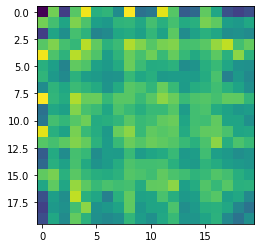

In [96]:
plt.imshow(dataset.uns["Sigma_x_inv"]["0"])

In [159]:
dataset.obs.index

Index(['115_198', '115_200', '116_198', '116_199', '116_211', '116_212',
       '116_213', '116_214', '116_215', '116_216',
       ...
       '225_271', '225_272', '225_273', '225_274', '225_275', '225_276',
       '228_197', '228_198', '229_181', '233_198'],
      dtype='object', name='cell_name', length=2816)

In [162]:
embedding_dataframe = pd.DataFrame(dataset.obsm["X"])
embedding_dataframe.index = dataset.obs.index
dataset.obsm["X"] = embedding_dataframe

In [ ]:
original_dataset = ad.read_h5ad(data_directory / "../E10.5_E1S1.MOSTA.h5ad")

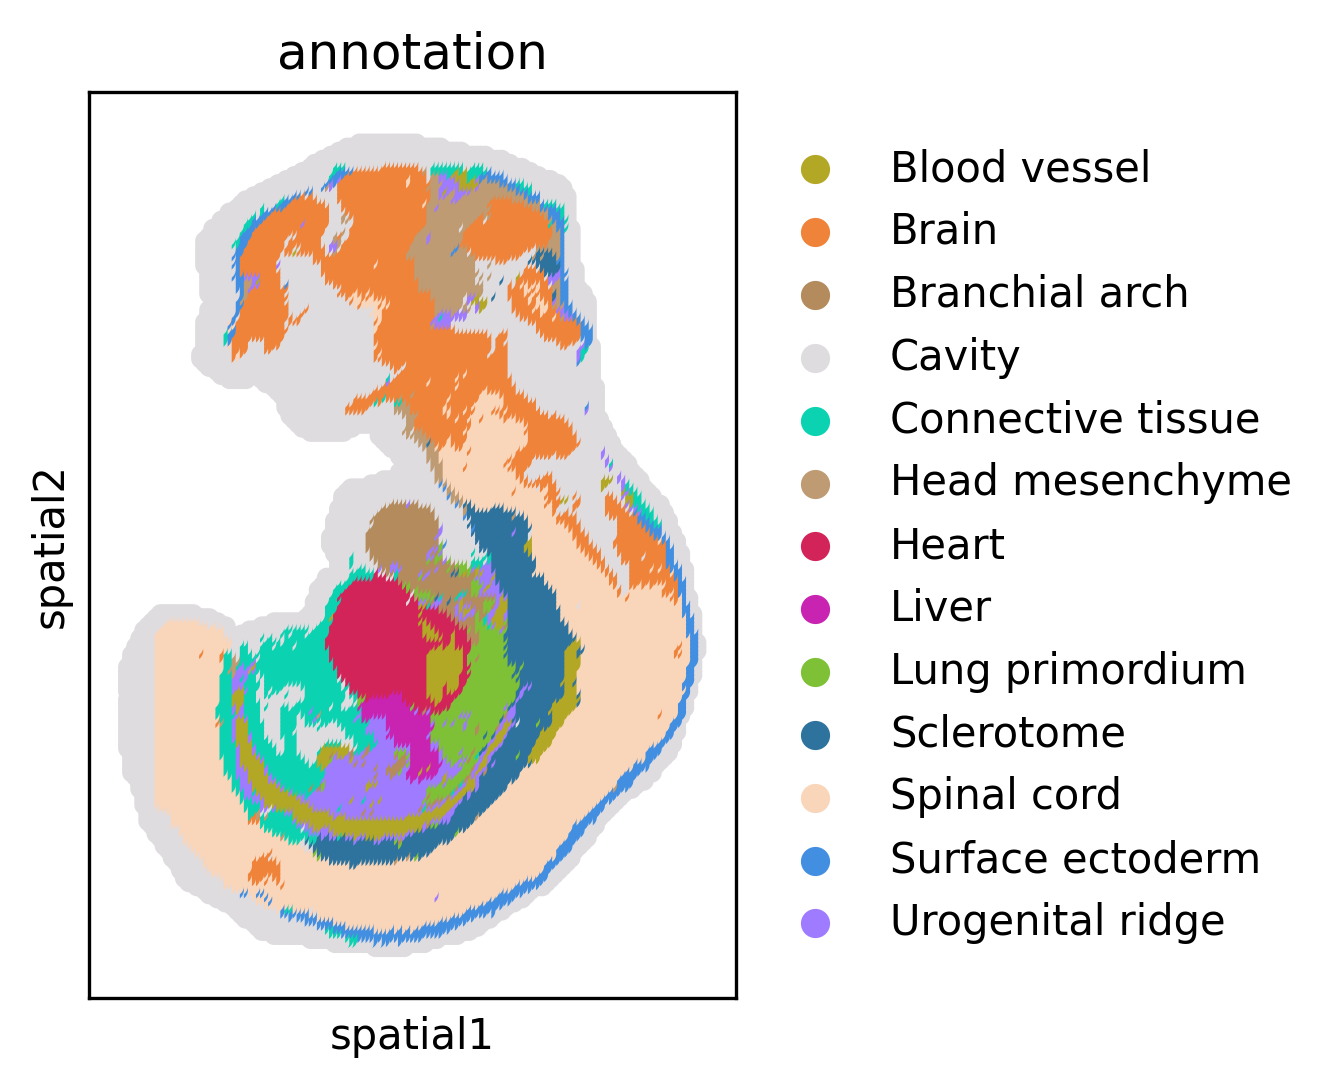

In [179]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot()
sc.pl.spatial(
    original_dataset,
    color="annotation",
    spot_size=5,
    ax=ax
)

In [184]:
fig.dpi

300

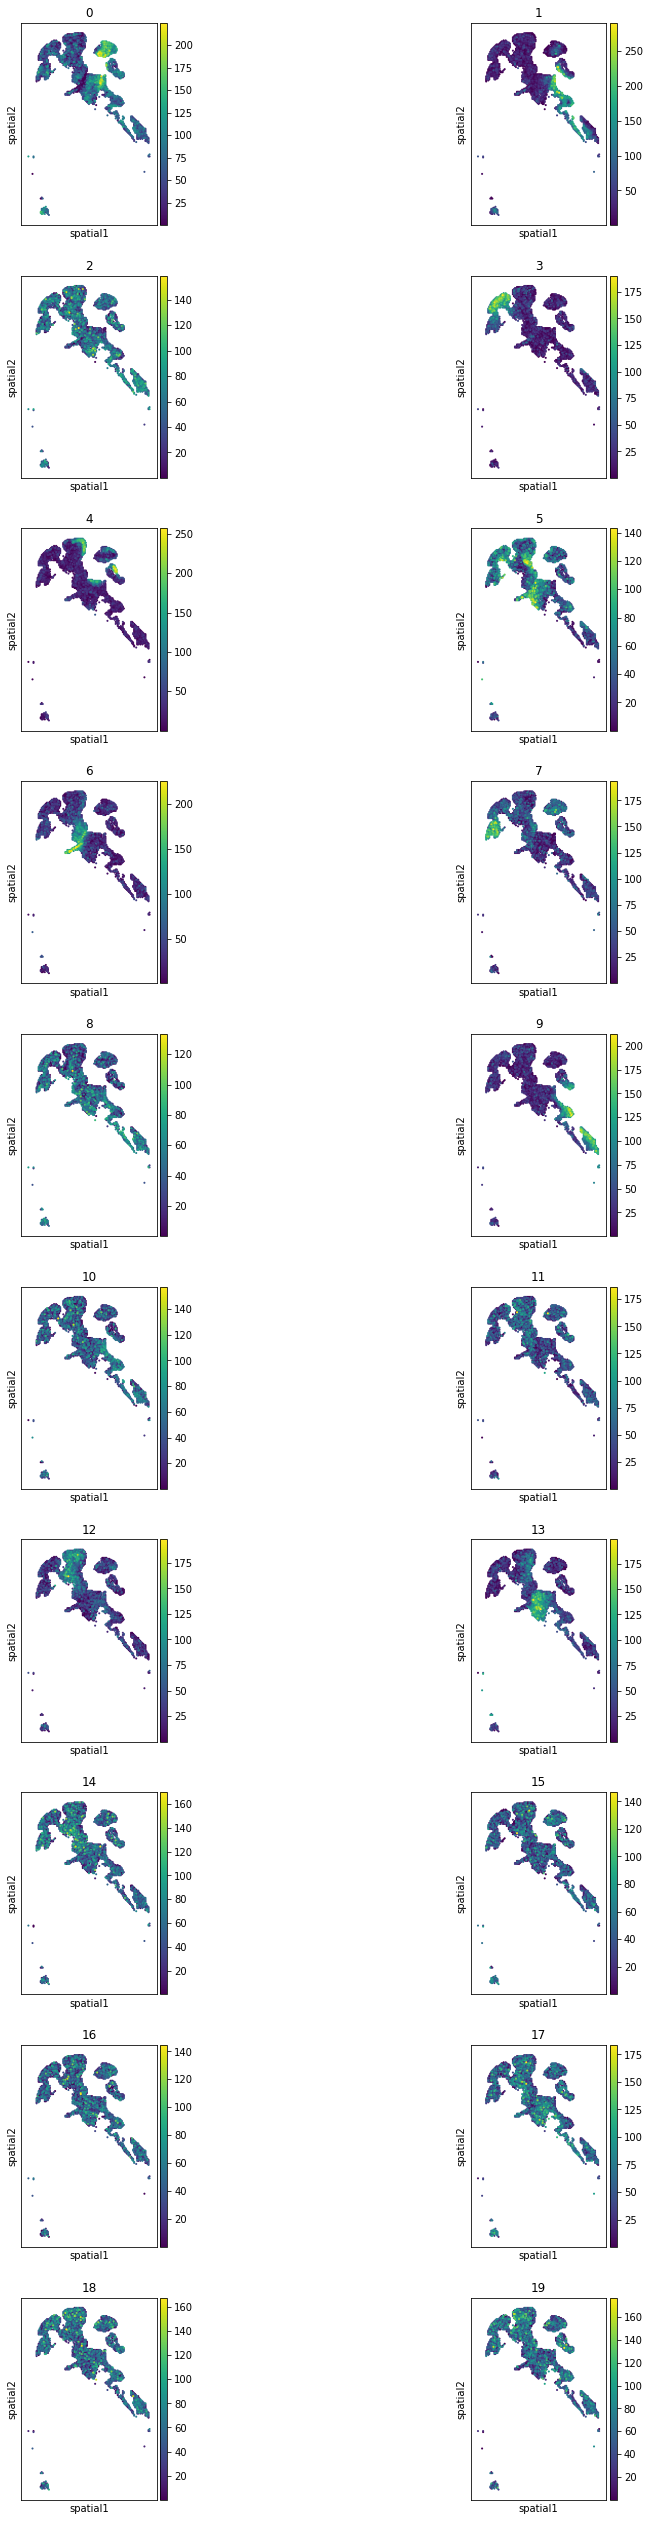

ValueError: too many values to unpack (expected 2)

In [186]:
fig, axes = sc.pl.spatial(
    sq.pl.extract(dataset, "X"),
    color=[f"{index}" for index in range(20)],
    spot_size=2,
    wspace=0.2,
    ncols=2,
    return_fig=True
)

axes

In [145]:
indices = np.argpartition(dataset.obsm["X"][:, 0], -10)[-10:]
dataset.var.index[indices]

Index(['Slc7a10', 'Tle4', 'Ccdc40', 'Zfp959', 'Ube2d2a', 'Thrap3', 'Gli3',
       'Sox3', 'Smo', 'Zic4'],
      dtype='object', name='gene_short_name')